In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy.api as sc
import scipy as sci
import re
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sc.settings.verbosity = 3 # amount of output
dir_root = '/Users/david.fischer/phd/data/Pseudodynamics/klein15/'
dirin = dir_root+'raw/'
sc.settings.figdir = dir_root+'scanpy_figs/'
sc.settings.writedir = dir_root+'scanpy_1_2/'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
print (sys.version)

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


scanpy==1.2.2+94.gdd36537 anndata==0.6.6 numpy==1.15.0 scipy==1.1.0 pandas==0.23.3 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


# Load data.

In [2]:
filename = dirin+'klein15_matrix_CellCylceCorrFromDPT.csv'
adata = sc.read(filename, cache=False)
meta = np.genfromtxt(dirin+'klein15_cellLabels_CellCylceCorrFromDPT.csv', dtype=str)
adata.obs['time'] = [{'1':0, '2':2, '3':4, '4':7}[x] for x in meta.astype(str)]
adata.obs_names = ['c'+str(i+1) for i,x in enumerate(adata.obs_names)]
adata.obs['cell'] = adata.obs_names

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


# Compute embedding: cell state

In [3]:
sc.pp.pca(adata, n_comps=50, random_state=0)
sc.pp.neighbors(adata, n_neighbors=20, knn=False, method='gauss', random_state=0)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.60) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.0000011  0.95624924 0.8824278  0.85866755 0.7968313  0.7090117
     0.695301   0.6724898  0.6338751  0.6066532  0.60313433 0.5868754
     0.5599899  0.554991   0.5183276 ]
    finished (0:00:01.60) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


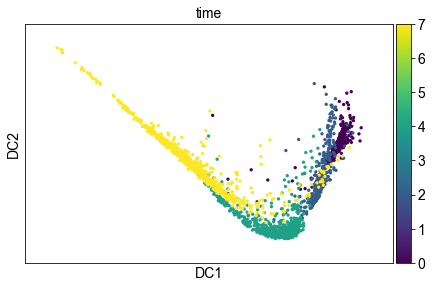

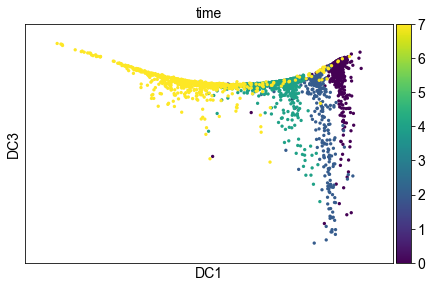

In [4]:
sc.pl.diffmap(adata, components='1,2', color="time")
sc.pl.diffmap(adata, components='1,3', color="time")

In [5]:
idxRoot = np.argmax(adata.obsm['X_diffmap'][:,1])
print(idxRoot) # 21
adata.uns['iroot'] = idxRoot

21


In [6]:
# compute cell state ordering: diffusion pseudotime
sc.tl.dpt(adata, n_branchings=0, min_group_size=100)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


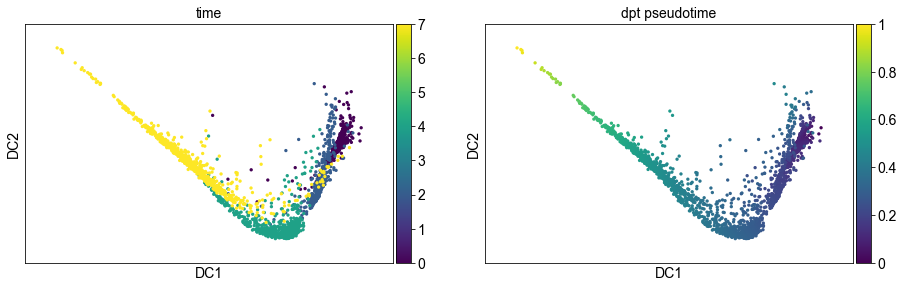

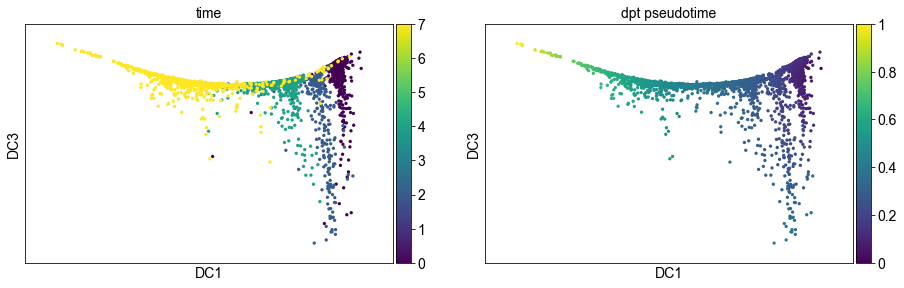

In [7]:
sc.pl.diffmap(adata, components='1,2', color=['time', 'dpt_pseudotime'])
sc.pl.diffmap(adata, components='1,3', color=['time', 'dpt_pseudotime'])

# Save results

In [8]:
sc.write(sc.settings.writedir+'klein15_cc.h5ad', adata)

In [9]:
np.savetxt(sc.settings.writedir+'DiffMap_klein15.csv', adata.obsm['X_diffmap'], delimiter=",")
pandas.DataFrame(adata.obs).to_csv(path_or_buf=sc.settings.writedir+'dpt_klein15.csv')

## Prepare pseudodynamics input

This is the text file that is used in the Matlab code that we use to fit the pseudodynamics model (the system of partial differential equations).

In [10]:
pd_in = pandas.DataFrame({
    'pseudodynamics_branching_region': 'nonbranching',
    'pseudodynamics_branch_class': 'main',
    'dpt_adjusted_groups': 'none',
    'time':adata.obs['time'],
    'batch': ['timebatch_' + str(x) for x in adata.obs['time'].values],
    'pseudotime':adata.obs['dpt_pseudotime'],
    'cell':adata.obs_names,
    'dc1':adata.obsm['X_diffmap'][:,1], 
    'dc2':adata.obsm['X_diffmap'][:,2],
    'dc3':adata.obsm['X_diffmap'][:,3],
    'dc4':adata.obsm['X_diffmap'][:,4] 
})

In [11]:
pd_in.to_csv(path_or_buf=sc.settings.writedir+'pseudodynamics_input_Klein15_dpt_DPTpaperProcessedData.csv')

# Compare against old results

Pseudodynamics model fitting is very computation intentsive, we ran pseudodynamics on an an embedding created with an older version of scanpy. We provide this section of the notebook to show that this old embedding is similar to the embedding that is created with newer versions of scanpy (this notebook was written for 1.2).

## Processed input for pseudodynamics

In [12]:
in_old = pandas.read_csv(dir_root+'input/pseudodynamics_input_Klein15_dpt_DPTpaperProcessedData.csv')

In [13]:
print('Dimensions of input objects match: '+str(np.all(in_old.shape==pd_in.shape)))
print('Column names of input objects match: '+str(np.all(in_old.columns==pd_in.columns)))

Dimensions of input objects match: True
Column names of input objects match: True


Test equality of selected columns. 

In [14]:
print('Cell IDs are the same: '+str(all(in_old['cell'].values==pd_in['cell'].values)))
print('Time labels are the same: '+str(all(in_old['time'].values==pd_in['time'].values)))
print('Maximum pseudotime deviation: '+str(np.max(in_old['pseudotime'].values-pd_in['pseudotime'].values)))

Cell IDs are the same: True
Time labels are the same: True
Maximum pseudotime deviation: 4.649162292980069e-06
